In [ ]:
pip install git+https://github.com/crispitagorico/sigkernel.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/crispitagorico/sigkernel.git to /tmp/pip-req-build-4ar574rl
  Running command git clone -q https://github.com/crispitagorico/sigkernel.git /tmp/pip-req-build-4ar574rl


In [ ]:
!pip install torch==1.9.0 torchvision==0.10.0 torchaudio==0.9.0 torchtext==0.10.0
!pip uninstall transformers
!pip install transformers==4.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: transformers 4.8.0
Uninstalling transformers-4.8.0:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.7/dist-packages/transformers-4.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/transformers/*
Proceed (y/n)? n
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import scipy
import torch
import sigkernel
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm
sns.set(style="darkgrid", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#gpu=0
#device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")
#if torch.cuda.is_available():
    #torch.cuda.set_device(device)

In [ ]:
class KernelPathHeat:
  def __init__(self,m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m):
        self.m_A=m_A
        self.m_B=m_B
        self.l=l
        self.T=T
        self.H=H
        self.sigma=sigma
        self.scale=scale
        self.f=f
        self.nu=nu
        self.strike=strike
        self.m=m
        self.t_grid_A=np.linspace(0,T,l)
        self.t_grid_B=T*np.ones((m_B))
        #self.seed=seed
  def h_path(self,t_grid):
    self.m_A=np.shape(t_grid)[0]
    times=np.linspace(0,self.T,self.l)
    self.h_path_path=torch.zeros((self.m_A,self.l,2))
    for i in range (self.m_A):
        for j in range (self.l):
            if times[j]>t_grid[i]:
                self.h_path_path[i,j,1]=np.sqrt(2.*self.H)*(times[j]-t_grid[i])**(self.H-0.5)
    return self.h_path_path          
    #return self.h_path_path

  def generator(self,n,seed):
    dt=self.T/self.l
    t=n*dt #now time
    path=np.zeros((self.l,))
    np.random.seed(seed)
    inc_bm=np.sqrt(dt)*np.random.normal(size=self.l) # generate increments at each dt step
    '''
    calculate the path 
    '''
    for j in range (1,self.l):
      s=j*dt 
      fbm=lambda r: ((s-r)**(self.H-0.5))*np.sqrt(2.*self.H)
      if s <=t: #means time [0,t]
          for i in range(j-1): #time [0,s]
            t_inf,t_sup=i*dt,(i+1)*dt
            integral,_=scipy.integrate.quadrature(fbm,t_inf,t_sup)
            path[j]+=integral*inc_bm[i+1]
          path[j]/=dt # record the location at each step 
      else: #[t,T]
          for i in range (n-1): # time [0,t]
            t_inf,t_sup=i*dt,(i+1)*dt
            integral,_=scipy.integrate.quadrature(fbm,t_inf,t_sup)
            path[j]+=integral*inc_bm[i+1]
          path[j]/=dt # record the location at each step 
        
    K_T=lambda r : ((self.T-r)**(self.H-0.5))*np.sqrt(2.*self.H)
    theta=0
    '''
     calculate the theta_t
    '''
    for i in range (n-1):
      t_inf,t_sup=i*dt,(i+1)*dt
      integral,_=scipy.integrate.quadrature(K_T,t_inf,t_sup)
      theta+=integral*inc_bm[i+1]
    theta/=dt

    # payoff (return conditional expectation )
    if self.f=='id':
        cond_exp = theta
    elif self.f=='abs':
        cond_exp = np.abs(theta) + ((self.T-t)**H) * np.sqrt(2./np.pi)
    elif self.f=='exp':
        cond_exp = np.exp(self.nu*theta + 0.5*(self.nu**2)*((self.T-t)**(2*self.H)))
    elif self.f=='call':
        cond_exp = ((self.T-t)**H) / np.sqrt(2.*np.pi) * np.exp( - ((self.strike-theta)**2) / 2*((self.T-t)**(2*self.H)) ) - (self.strike-theta)*scipy.stats.norm.cdf((theta-self.strike)/((self.T-t)**self.H))
    elif self.f=='exp_call': 
        cond_exp = np.exp(0.5*(self.T-t)**(2*self.H)+theta) * scipy.stats.norm.cdf((self.T-t)**self.H - (np.log(self.strike)-theta)/((self.T-t)**self.H)) - strike*scipy.stats.norm.cdf(-(np.log(self.strike)-theta)/((self.T-t)**self.H)) 
    else:
        raise Exception('payoff structure not implemented') 


    return torch.tensor(path),cond_exp

  def generatePath_A(self):
    path_A=torch.zeros((self.m_A,self.l,2)) 
    j=0
    for i in tqdm.tqdm(range(self.m_A)):
      path_A[j,:,0] = torch.tensor(self.t_grid_A)
      path_A[j,:,1], _ = self.generator(i,j)
      j+=1
    return path_A

  def generatePath_B(self):
    path_B=torch.zeros((self.m_B,self.l,2)) 
    j=0
    for i in tqdm.tqdm(range(self.m_B)):
      path_B[j,:,0] = torch.tensor(self.t_grid_A)
      path_B[j,:,1], _ = self.generator(self.l,j)
      j+=1
    return path_B

  def generatePaths(self):
    time_indices = [(i,t_i) for i,t_i in zip(np.arange(self.l), np.linspace(0,self.T,self.l))]
    #np.random.seed(self.seed)
    time_indices_ = random.sample(time_indices, self.m) #generate random m groups 
    t_grid = [t for _,t in time_indices_]
    t_grid.sort()
    t_grid = torch.tensor(t_grid)
    t_ind = [i for i,_ in time_indices_] # index of the m groups
    t_ind.sort()

    paths = torch.zeros((self.m,self.l,2))
    cond_exp = torch.zeros((self.m,))
    j=0
    for i in tqdm.tqdm(t_ind):
      paths[j,:,0] = torch.tensor(self.t_grid_A)
      paths[j,:,1], cond_exp[j]= self.generator(i,j)
      j+=1
    
      # derivative paths
    h = self.scale*self.h_path(t_grid)

# true solution
    sol_true = cond_exp.cpu()
      #return h, paths,sol_true
    return paths,sol_true

In [ ]:
from inspect import signature
eps=1e-12
#define the exponentila term (convinent for differential)
def exp_term(t,t_prime,sigma):
  return np.exp(-(t-t_prime)**2/(2*sigma**2))

#define the first derivative for the first element (gamma)
def path_derivative10(G_sig,gamma,gamma_prime,h,eps,sigma):
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  gamma_h=torch.zeros_like(gamma)
  m=gamma.shape[0]
  for i in range (m):
    gamma_h[i]=gamma[i]+eps*h[i]
  G_sig_h=signature_kernel.compute_Gram(gamma_h.to(device),gamma_prime.to(device))
  return (G_sig_h-G_sig)/eps

#define the first derivative for the second element (gamma_prime)
def path_derivative01(G_sig,gamma,gamma_prime,h,eps,sigma):
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  gamma_prime_h=torch.zeros_like(gamma_prime)
  m_prime=gamma_prime.shape[0]
  for i in range (m_prime):
    gamma_prime_h[i]=gamma_prime[i]+eps*h[i]
  G_sig_h=signature_kernel.compute_Gram(gamma.to(device),gamma_prime_h.to(device))
  return (G_sig_h-G_sig)/eps

#define the second derivative for the first element (gamma)
def path_derivative20(G_sig,gamma,gamma_prime,h,eps,sigma):
  return path_derivative10(path_derivative10(G_sig,gamma,gamma_prime,h,eps,sigma),gamma,gamma_prime,h,eps,sigma)

#define the second derivative for the second element (gamma_prime)
def path_derivative02(G_sig,gamma,gamma_prime,h,eps,sigma):
  return path_derivative01(path_derivative01(G_sig,gamma,gamma_prime,h,eps,sigma),gamma,gamma_prime,h,eps,sigma)

#define the second derivative for the first element and second element (gamma, gamma_prime)
def path_derivative22(G_sig,gamma,gamma_prime,h,eps,sigma):
  return path_derivative02(path_derivative20(G_sig,gamma,gamma_prime,h,eps,sigma),gamma,gamma_prime,h,eps,sigma)

#define the first derivative of operator L for the first element 
def L10(G_sig,gamma,gamma_prime,t_grid,t_grid_prime,h,sigma,eps):
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  G_sig_h=path_derivative20(G_sig,gamma,gamma_prime,h,eps,sigma)
  L=torch.zeros_like(G_sig)
  n,n_prime=t_grid.shape[0],t_grid_prime.shape[0]
  for i in range (n):
    for j in range(n_prime):
      t=t_grid[i]
      t_prime=t_grid_prime[j]
      exp=exp_term(t,t_prime,sigma)
      L1=((t_prime-t)/(sigma**2))*exp*G_sig[i,j]
      L2=0.5*exp*G_sig_h[i,j]
      L[i,j]=L1+L2
  return L

def L01(G_sig,gamma,gamma_prime,t_grid,t_grid_prime,h,sigma,eps):
  G_sig_h_=path_derivative02(G_sig,gamma,gamma_prime,h,eps,sigma)
  L=torch.zeros_like(G_sig)
  n,n_prime=t_grid.shape[0],t_grid_prime.shape[0]
  for i in range (n):
    for j in range(n_prime):
      t=t_grid[i]
      t_prime=t_grid_prime[j]
      exp=exp_term(t,t_prime,sigma)
      L1=((t-t_prime)/(sigma**2))*exp*G_sig[i,j]
      L2=0.5*exp*G_sig_h_[i,j]
      L[i,j]=L1+L2
  return L


#define the first derivative of operator L for the firsr element and second element 
def L11(G_sig,gamma,gamma_prime,t_grid,t_grid_prime,h,sigma,eps):
  G_sig_h=path_derivative20(G_sig,gamma,gamma_prime,h,eps,sigma)
  G_sig_h_prime=path_derivative02(G_sig,gamma,gamma_prime,h,eps,sigma)
  G_sig_h_h_prime=path_derivative22(G_sig,gamma,gamma_prime,h,eps,sigma)
  L=torch.zeros_like(G_sig)
  n,n_prime=t_grid.shape[0],t_grid_prime.shape[0]
  for i in range (n):
    for j in range(n_prime):
      t=t_grid[i]
      t_prime=t_grid_prime[j]
      exp=exp_term(t,t_prime,sigma)
      L1=((sigma**2-(t-t_prime)**2)/sigma**4)*exp*G_sig[i,j]
      L2=(t-t_prime)/(2*sigma**2)*exp*G_sig_h[i,j]
      L3=(t_prime-t)/(2*sigma**2)*exp*G_sig_h_prime[i,j]
      L4=0.25*exp*G_sig_h_h_prime[i,j]
      L[i,j]=L1+L2+L3+L4
  return L

In [ ]:
def generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A):
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  G_AA_sig = signature_kernel.compute_Gram(path_A.to(device), path_A.to(device), sym=True) # shape (m_A, m_A)
  G_AA = L11(G_AA_sig, path_A,  path_A,t_grid_A, t_grid_A, h_A, sigma,eps)

  G_AB_sig = signature_kernel.compute_Gram(path_A.to(device), path_B.to(device), sym=False) # shape (m_A, m_B)
  G_AB = L10(G_AB_sig, path_A,path_B, t_grid_A,  t_grid_B, h_A, sigma,eps)

  G_BA = -G_AB.transpose(0,1)# shape (m_B, m_A)

  G_BB = signature_kernel.compute_Gram(path_B.to(device), path_B.to(device), sym=True) # shape (m_B, m_B)

  # final Gram matrix G
  G_up = torch.cat([G_AA, G_AB], dim=1)
  G_down = torch.cat([G_BA, G_BB], dim=1)
  G = torch.cat([G_up, G_down], dim=0) # shape (m_A+m_B, m_A+m_B)
  return G

def generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma):
  eps=1e-12
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  X_sig=signature_kernel.compute_Gram(paths.to(device), path_A.to(device), sym=False)#30*60
  X_sig_A=L01(X_sig,paths,path_A,t_grid,t_grid_A,h,sigma,eps)#30*60
  X_sig_B=signature_kernel.compute_Gram(paths.to(device), path_B.to(device), sym=False)#30*60
  X = torch.cat([X_sig_A, X_sig_B], dim=1)#30*120
  return X 

def generateY(f,m_A,m_B,path_B,strike,nu):
  # payoffs
  if f=='id':
      f_ = lambda x : x
  elif f=='abs':
      f_ = lambda x : np.abs(x)
  elif f=='exp':
      f_ = lambda x : np.exp(nu*x)
  elif f=='call':
      f_ = lambda x : np.maximum(0., x - strike)
  elif f=='exp_call': 
      f_ = lambda x : np.maximum(0., np.exp(x) - strike) 
  else:
      raise Exception('payoff structure not implemented') 

    # boundary conditions
  y = torch.zeros((m_A + m_B,1))
  for i in range(m_B):
    y[m_A + i] = f_(path_B[i][-1,-1]) 
  return y

In [ ]:
def generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma):
  eps=1e-12
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  X_sig=signature_kernel.compute_Gram(path_A.to(device), paths.to(device), sym=False)
  X_sig_A=L10(X_sig,path_A,paths,t_grid_A,t_grid,h_A,sigma,eps)
  X_sig_B=signature_kernel.compute_Gram(path_B.to(device), paths.to(device), sym=False)
  X = torch.cat([X_sig_A, X_sig_B], dim=0)
  return X 

In [ ]:
def generateK(paths,t_grid,sigma):
  static_kernel = sigkernel.RBFKernel(sigma=sigma)
  signature_kernel = sigkernel.SigKernel(static_kernel, dyadic_order=1)
  G_sig=signature_kernel.compute_Gram(paths.to(device), paths.to(device), sym=False)
  n=t_grid.shape[0]
  K=torch.zeros((n,n))
  for i in range (n):
    for j in range(n):
      t=t_grid[i]
      t_prime=t_grid[j]
      exp=exp_term(t,t_prime,sigma)
      K[i,j]=exp*G_sig[i,j]
  return K

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=1.

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
#np.random.seed(seed)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


In [ ]:
def r2(x, y):
    return scipy.stats.pearsonr(x, y)[0] ** 2

# Plot for id

100%|██████████| 60/60 [00:05<00:00, 10.86it/s]


 sigma = 1 --- r2 = 0.989


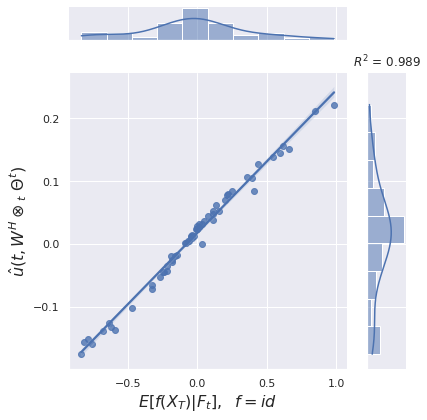

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='id'
nu=1.
strike=0.7

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

# Plot for Abs


100%|██████████| 60/60 [00:05<00:00, 11.69it/s]


 sigma = 1 --- r2 = 0.839


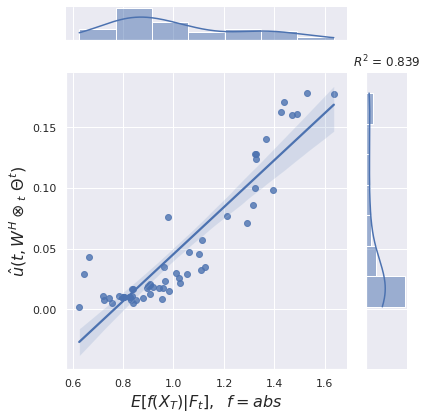

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='abs'
nu=1.
strike=0.7

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h_A,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

# Plot for Exp


100%|██████████| 60/60 [00:05<00:00, 11.62it/s]


 sigma = 1 --- r2 = 0.937


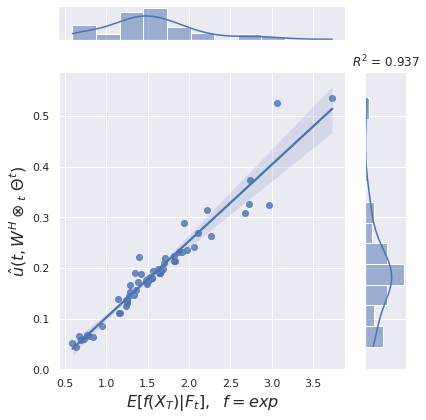

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp'
nu=1.
strike=0.7

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

# Plot for call

100%|██████████| 30/30 [00:00<00:00, 45.47it/s]


 sigma = 1 --- r2 = 0.966


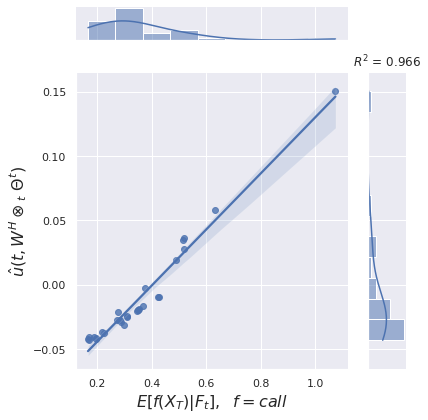

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='call'
nu=1.
strike=0.1

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

# Plot for expcall

100%|██████████| 30/30 [00:00<00:00, 42.14it/s]


 sigma = 1 --- r2 = 0.955


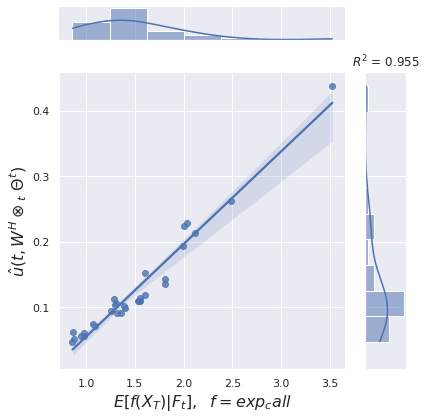

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.1

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

# Plot for samples 

## Plot for id

100%|██████████| 60/60 [00:07<00:00,  8.05it/s]


 sigma = 15.0 --- r2 = 0.999


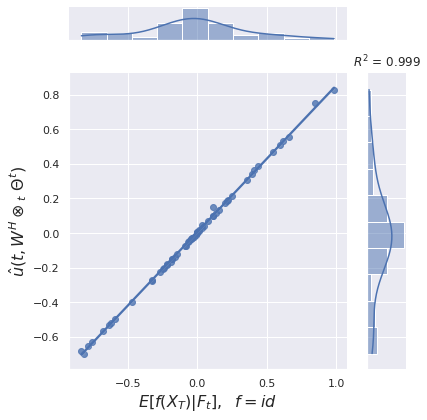

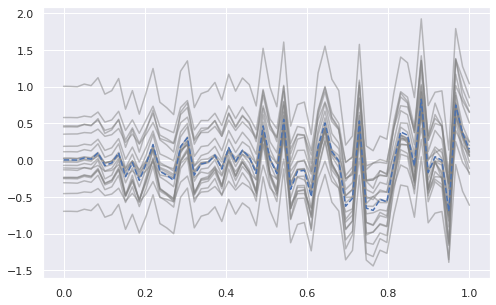

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='id'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$','$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 

#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

## Plot for abs  

100%|██████████| 60/60 [00:06<00:00,  8.83it/s]


 sigma = 15.0 --- r2 = 0.781


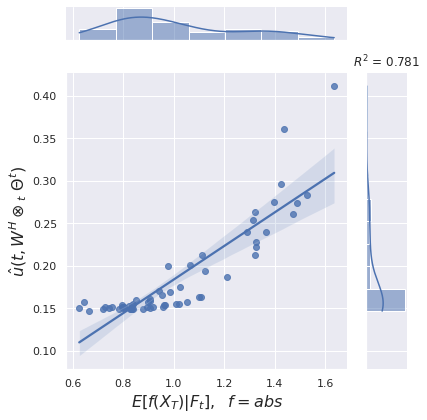

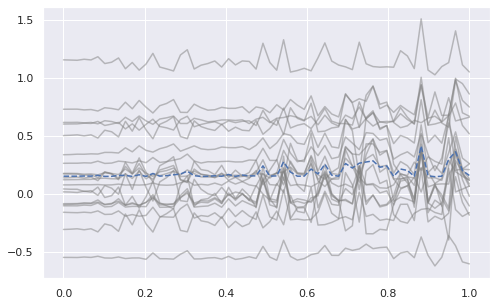

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='abs'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$','$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 

#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

## Plot for exp

100%|██████████| 60/60 [00:05<00:00, 11.72it/s]


 sigma = 15.0 --- r2 = 0.96


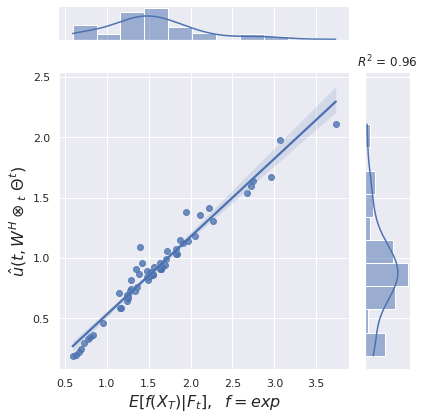

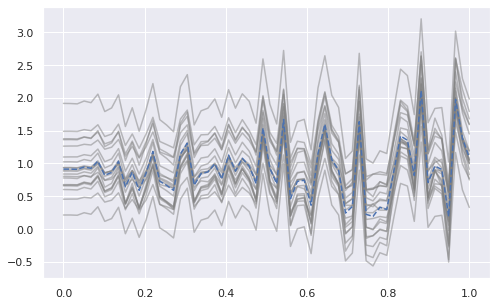

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='exp'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$','$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 


#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

## Plot for call

100%|██████████| 60/60 [00:05<00:00, 11.65it/s]


 sigma = 15.0 --- r2 = 0.961


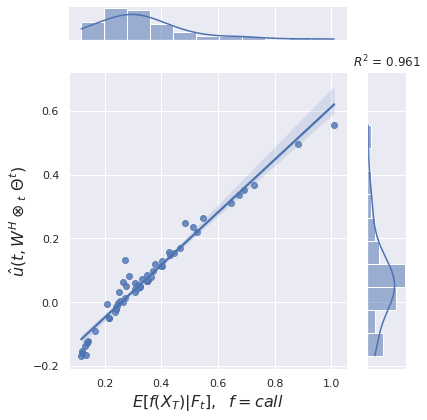

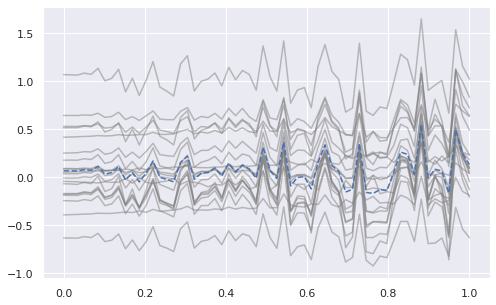

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='call'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$','$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 

#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

## Plot for exp_call

100%|██████████| 60/60 [00:05<00:00, 11.47it/s]


 sigma = 15.0 --- r2 = 0.959


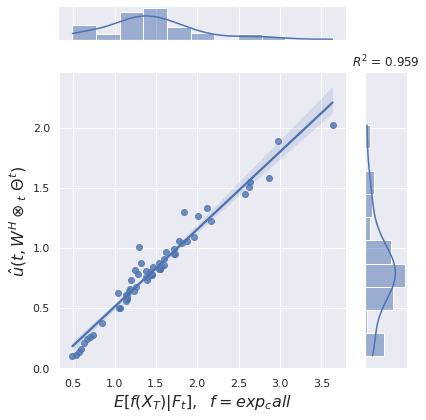

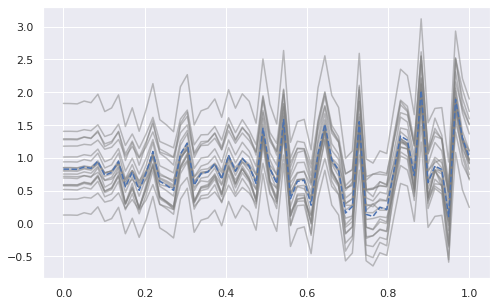

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='exp_call'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_true, y=sol_pred, kind='reg')
fig.set_axis_labels(f'$E[f(X_T) | F_t], \ \ f={f}$','$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 

#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

In [ ]:
m_A=60
m_B=60
H=0.1
l=m_A
T=1
sigma=15.
scale=0.01

#payoff
f='abs'
nu=1.
strike=0.1

m=60
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
h_A=scale*a.h_path(t_grid_A)
path_A=a.generatePath_A()
path_B=a.generatePath_B()
paths,sol_true=a.generatePaths()
h=scale*a.h_path(t_grid)

path_A=path_A.double()
path_B=path_B.double()
paths=paths.double()

y=generateY(f,m_A,m_B,path_B,strike,nu)
G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
G_inv = torch.cholesky_inverse(G)

x=x.double()
y=y.double()
G_inv=G_inv.double()

X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
K1=generateK(paths,t_grid,sigma)
cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
pred=pred.cpu().numpy()
pred=pred.reshape(1,-1)
pred=pred[0,:]

final_r2 = 0.
temp_r2 = r2(sol_true,pred)
print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
if temp_r2 > final_r2:
  final_r2 = temp_r2
  sol_pred = pred
fig = sns.jointplot(x=sol_pred, y=sol_true, kind='reg')
fig.set_axis_labels('$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', f'$E[f(X_T) | F_t], \ \ f={f}$', fontsize=16) 

#(f'$E[f(X_T) | F_t], \ \ f={f}$', '$\hat{u}(t,W^H \otimes_t \ \Theta^t)$', fontsize=16) 
plt.title(f"$R^2$ = {np.round(final_r2,3)}")
plt.tight_layout()
plt.savefig(f'f={f}')
plt.show()

plt.figure(figsize=(8,5))
h_samples = plt.plot(t_grid, np.random.multivariate_normal(sol_pred, cov, 20).T, c='gray', alpha=0.5);
h_mean = plt.plot(t_grid, sol_pred, linestyle='--', label='Mean Function')

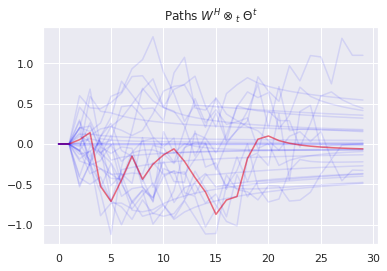

In [ ]:
for i in range(m_A):
    path = path_A.numpy()[i,:,1]
    plt.plot(path, c='blue', alpha=0.1)

plt.plot(path_A.numpy()[20,:,1], c='red', alpha=0.5)
plt.title('Paths $W^H \otimes_t \ \Theta^t$')
plt.show()

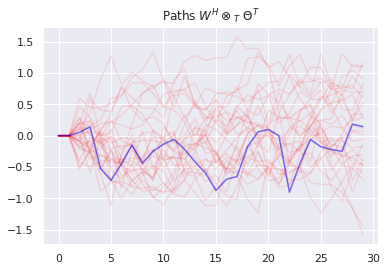

In [ ]:
for i in range(m_B):
    path = path_B.numpy()[i,:,1]
    plt.plot(path, c='red', alpha=0.1)
plt.plot(path_B.numpy()[20,:,1], c='blue', alpha=0.5)
plt.title('Paths $W^H \otimes_T \ \Theta^T$')
plt.show()

# Test sigma

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.1

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))

## For id

In [ ]:
f='id'
sigma_list=np.linspace(0.1,10,19)
error_sigma=np.zeros((len(sigma_list)))
R2_sigma=np.zeros((len(sigma_list)))
cov_sigma=np.zeros((len(sigma_list)))
for i in range (len(sigma_list)):
  m_A=30
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  #sigma=1
  sigma=sigma_list[i]
  scale=1e-2

  #payoff
  f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_sigma[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_sigma[i]=np.round(final_r2,3)
  cov_sigma[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 43.08it/s]


 sigma = 0.1 --- r2 = 0.87


100%|██████████| 30/30 [00:00<00:00, 39.93it/s]


 sigma = 0.65 --- r2 = 0.983


100%|██████████| 30/30 [00:00<00:00, 44.86it/s]


 sigma = 1.2 --- r2 = 0.991


100%|██████████| 30/30 [00:00<00:00, 37.85it/s]


 sigma = 1.75 --- r2 = 0.994


100%|██████████| 30/30 [00:00<00:00, 43.96it/s]


 sigma = 2.3 --- r2 = 0.995


100%|██████████| 30/30 [00:00<00:00, 44.77it/s]


 sigma = 2.85 --- r2 = 0.996


100%|██████████| 30/30 [00:00<00:00, 45.72it/s]


 sigma = 3.4 --- r2 = 0.996


100%|██████████| 30/30 [00:00<00:00, 44.75it/s]


 sigma = 3.95 --- r2 = 0.997


100%|██████████| 30/30 [00:00<00:00, 43.96it/s]


 sigma = 4.5 --- r2 = 0.997


100%|██████████| 30/30 [00:00<00:00, 45.07it/s]


 sigma = 5.05 --- r2 = 0.998


100%|██████████| 30/30 [00:00<00:00, 45.29it/s]


 sigma = 5.6 --- r2 = 0.998


100%|██████████| 30/30 [00:00<00:00, 44.86it/s]


 sigma = 6.15 --- r2 = 0.998


100%|██████████| 30/30 [00:00<00:00, 45.02it/s]


 sigma = 6.7 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 44.96it/s]


 sigma = 7.25 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 43.33it/s]


 sigma = 7.8 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 44.55it/s]


 sigma = 8.35 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 44.82it/s]


 sigma = 8.9 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 38.33it/s]


 sigma = 9.45 --- r2 = 0.999


100%|██████████| 30/30 [00:00<00:00, 45.86it/s]


 sigma = 10.0 --- r2 = 0.999


Text(0, 0.5, '$R^2$')

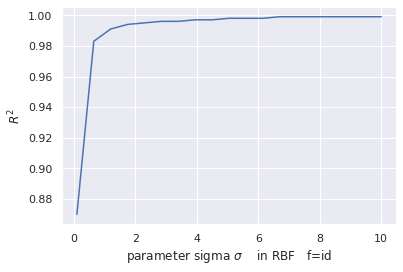

In [ ]:
plt.plot(sigma_list,R2_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

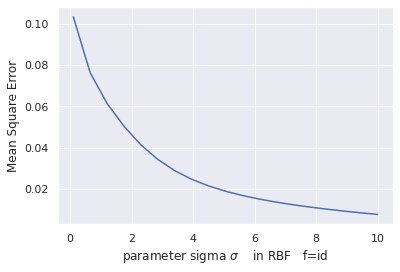

In [ ]:
plt.plot(sigma_list,error_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

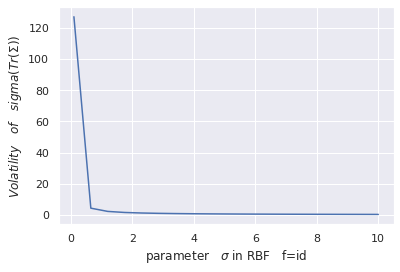

In [ ]:
plt.plot(sigma_list,cov_sigma)
plt.xlabel(f'parameter' '$\quad$' '$\sigma$' ' in RBF' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For abs

In [ ]:
f='abs'
sigma_list=np.linspace(0.1,10,19)
error_sigma=np.zeros((len(sigma_list)))
R2_sigma=np.zeros((len(sigma_list)))
cov_sigma=np.zeros((len(sigma_list)))
for i in range (len(sigma_list)):
  m_A=30
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  #sigma=1
  sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.1

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_sigma[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_sigma[i]=np.round(final_r2,3)
  cov_sigma[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 44.21it/s]


 sigma = 0.1 --- r2 = 0.431


100%|██████████| 30/30 [00:00<00:00, 45.20it/s]


 sigma = 0.65 --- r2 = 0.712


100%|██████████| 30/30 [00:00<00:00, 42.29it/s]


 sigma = 1.2 --- r2 = 0.726


100%|██████████| 30/30 [00:00<00:00, 44.75it/s]


 sigma = 1.75 --- r2 = 0.667


100%|██████████| 30/30 [00:00<00:00, 44.72it/s]


 sigma = 2.3 --- r2 = 0.581


100%|██████████| 30/30 [00:00<00:00, 43.13it/s]


 sigma = 2.85 --- r2 = 0.509


100%|██████████| 30/30 [00:00<00:00, 45.59it/s]


 sigma = 3.4 --- r2 = 0.457


100%|██████████| 30/30 [00:00<00:00, 44.77it/s]


 sigma = 3.95 --- r2 = 0.421


100%|██████████| 30/30 [00:00<00:00, 42.87it/s]


 sigma = 4.5 --- r2 = 0.396


100%|██████████| 30/30 [00:00<00:00, 44.61it/s]


 sigma = 5.05 --- r2 = 0.377


100%|██████████| 30/30 [00:00<00:00, 43.85it/s]


 sigma = 5.6 --- r2 = 0.363


100%|██████████| 30/30 [00:00<00:00, 44.10it/s]


 sigma = 6.15 --- r2 = 0.351


100%|██████████| 30/30 [00:00<00:00, 43.93it/s]


 sigma = 6.7 --- r2 = 0.341


100%|██████████| 30/30 [00:00<00:00, 45.66it/s]


 sigma = 7.25 --- r2 = 0.332


100%|██████████| 30/30 [00:00<00:00, 44.99it/s]


 sigma = 7.8 --- r2 = 0.324


100%|██████████| 30/30 [00:00<00:00, 43.83it/s]


 sigma = 8.35 --- r2 = 0.317


100%|██████████| 30/30 [00:00<00:00, 44.93it/s]


 sigma = 8.9 --- r2 = 0.31


100%|██████████| 30/30 [00:00<00:00, 46.05it/s]


 sigma = 9.45 --- r2 = 0.304


100%|██████████| 30/30 [00:00<00:00, 46.12it/s]


 sigma = 10.0 --- r2 = 0.298


Text(0, 0.5, '$R^2$')

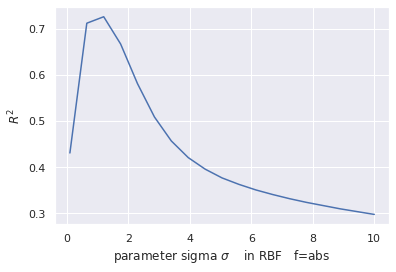

In [ ]:
plt.plot(sigma_list,R2_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

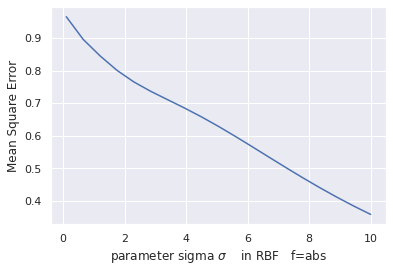

In [ ]:
plt.plot(sigma_list,error_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

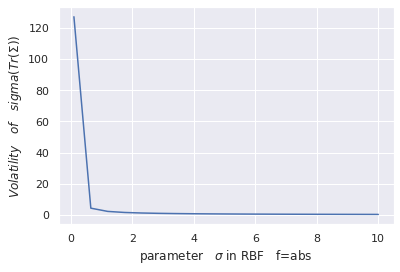

In [ ]:
plt.plot(sigma_list,cov_sigma)
plt.xlabel(f'parameter' '$\quad$' '$\sigma $' ' in RBF' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For exp

In [ ]:
f='exp'
sigma_list=np.linspace(0.1,10,19)
error_sigma=np.zeros((len(sigma_list)))
R2_sigma=np.zeros((len(sigma_list)))
cov_sigma=np.zeros((len(sigma_list)))
for i in range (len(sigma_list)):
  m_A=30
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  #sigma=1
  sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.1

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_sigma[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_sigma[i]=np.round(final_r2,3)
  cov_sigma[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 44.89it/s]


 sigma = 0.1 --- r2 = 0.301


100%|██████████| 30/30 [00:01<00:00, 25.21it/s]


 sigma = 0.65 --- r2 = 0.946


100%|██████████| 30/30 [00:00<00:00, 44.59it/s]


 sigma = 1.2 --- r2 = 0.953


100%|██████████| 30/30 [00:00<00:00, 43.58it/s]


 sigma = 1.75 --- r2 = 0.964


100%|██████████| 30/30 [00:00<00:00, 43.69it/s]


 sigma = 2.3 --- r2 = 0.972


100%|██████████| 30/30 [00:00<00:00, 43.18it/s]


 sigma = 2.85 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 44.75it/s]


 sigma = 3.4 --- r2 = 0.976


100%|██████████| 30/30 [00:00<00:00, 40.00it/s]


 sigma = 3.95 --- r2 = 0.976


100%|██████████| 30/30 [00:00<00:00, 43.21it/s]


 sigma = 4.5 --- r2 = 0.976


100%|██████████| 30/30 [00:00<00:00, 45.20it/s]


 sigma = 5.05 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 32.58it/s]


 sigma = 5.6 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 41.66it/s]


 sigma = 6.15 --- r2 = 0.974


100%|██████████| 30/30 [00:00<00:00, 31.26it/s]


 sigma = 6.7 --- r2 = 0.974


100%|██████████| 30/30 [00:01<00:00, 27.67it/s]


 sigma = 7.25 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 41.39it/s]


 sigma = 7.8 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 44.22it/s]


 sigma = 8.35 --- r2 = 0.972


100%|██████████| 30/30 [00:00<00:00, 44.70it/s]


 sigma = 8.9 --- r2 = 0.972


100%|██████████| 30/30 [00:00<00:00, 44.78it/s]


 sigma = 9.45 --- r2 = 0.971


100%|██████████| 30/30 [00:00<00:00, 42.62it/s]


 sigma = 10.0 --- r2 = 0.971


Text(0, 0.5, '$R^2$')

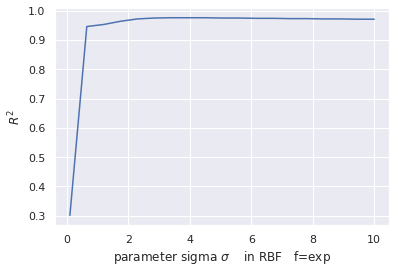

In [ ]:
plt.plot(sigma_list,R2_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

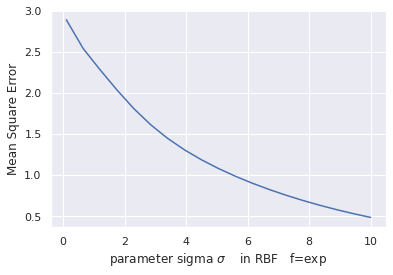

In [ ]:
plt.plot(sigma_list,error_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

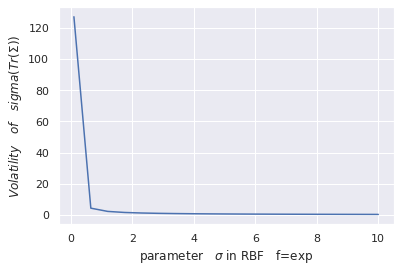

In [ ]:
plt.plot(sigma_list,cov_sigma)
plt.xlabel(f'parameter' '$\quad$' '$\sigma$' ' in RBF' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For call

In [ ]:
f='call'
sigma_list=np.linspace(0.1,10,19)
error_sigma=np.zeros((len(sigma_list)))
R2_sigma=np.zeros((len(sigma_list)))
cov_sigma=np.zeros((len(sigma_list)))
for i in range (len(sigma_list)):
  m_A=30
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  #sigma=1
  sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.1

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_sigma[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_sigma[i]=np.round(final_r2,3)
  cov_sigma[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 44.60it/s]


 sigma = 0.1 --- r2 = 0.842


100%|██████████| 30/30 [00:00<00:00, 44.67it/s]


 sigma = 0.65 --- r2 = 0.961


100%|██████████| 30/30 [00:00<00:00, 43.37it/s]


 sigma = 1.2 --- r2 = 0.97


100%|██████████| 30/30 [00:00<00:00, 43.81it/s]


 sigma = 1.75 --- r2 = 0.978


100%|██████████| 30/30 [00:00<00:00, 44.57it/s]


 sigma = 2.3 --- r2 = 0.979


100%|██████████| 30/30 [00:00<00:00, 45.09it/s]


 sigma = 2.85 --- r2 = 0.977


100%|██████████| 30/30 [00:00<00:00, 45.64it/s]


 sigma = 3.4 --- r2 = 0.974


100%|██████████| 30/30 [00:00<00:00, 45.70it/s]


 sigma = 3.95 --- r2 = 0.971


100%|██████████| 30/30 [00:00<00:00, 45.58it/s]


 sigma = 4.5 --- r2 = 0.969


100%|██████████| 30/30 [00:00<00:00, 46.28it/s]


 sigma = 5.05 --- r2 = 0.967


100%|██████████| 30/30 [00:00<00:00, 45.20it/s]


 sigma = 5.6 --- r2 = 0.966


100%|██████████| 30/30 [00:00<00:00, 44.86it/s]


 sigma = 6.15 --- r2 = 0.965


100%|██████████| 30/30 [00:00<00:00, 45.65it/s]


 sigma = 6.7 --- r2 = 0.964


100%|██████████| 30/30 [00:00<00:00, 45.88it/s]


 sigma = 7.25 --- r2 = 0.963


100%|██████████| 30/30 [00:00<00:00, 44.91it/s]


 sigma = 7.8 --- r2 = 0.962


100%|██████████| 30/30 [00:00<00:00, 45.23it/s]


 sigma = 8.35 --- r2 = 0.961


100%|██████████| 30/30 [00:00<00:00, 45.51it/s]


 sigma = 8.9 --- r2 = 0.96


100%|██████████| 30/30 [00:00<00:00, 45.24it/s]


 sigma = 9.45 --- r2 = 0.96


100%|██████████| 30/30 [00:00<00:00, 46.11it/s]


 sigma = 10.0 --- r2 = 0.959


Text(0, 0.5, '$R^2$')

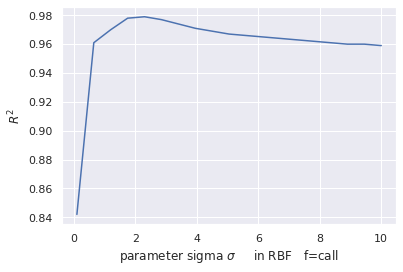

In [ ]:
plt.plot(sigma_list,R2_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' ' in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

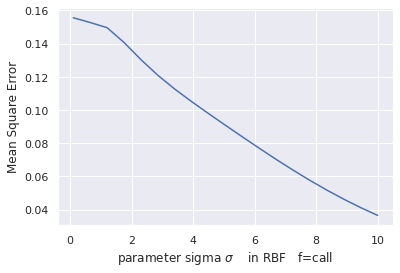

In [ ]:
plt.plot(sigma_list,error_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

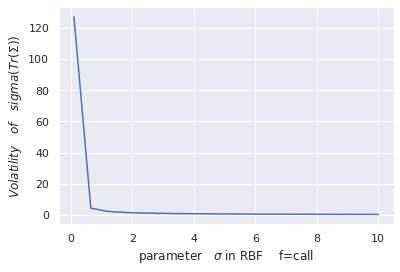

In [ ]:
plt.plot(sigma_list,cov_sigma)
plt.xlabel(f'parameter' '$\quad$' '$\sigma$' ' in RBF' ' $\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For expcall

In [ ]:
f='exp_call'
sigma_list=np.linspace(0.1,10,19)
error_sigma=np.zeros((len(sigma_list)))
R2_sigma=np.zeros((len(sigma_list)))
cov_sigma=np.zeros((len(sigma_list)))
for i in range (len(sigma_list)):
  m_A=30
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  #sigma=1
  sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.1

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_sigma[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_sigma[i]=np.round(final_r2,3)
  cov_sigma[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 45.39it/s]


 sigma = 0.1 --- r2 = 0.384


100%|██████████| 30/30 [00:00<00:00, 45.37it/s]


 sigma = 0.65 --- r2 = 0.953


100%|██████████| 30/30 [00:00<00:00, 45.21it/s]


 sigma = 1.2 --- r2 = 0.956


100%|██████████| 30/30 [00:00<00:00, 44.99it/s]


 sigma = 1.75 --- r2 = 0.966


100%|██████████| 30/30 [00:00<00:00, 45.02it/s]


 sigma = 2.3 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 44.94it/s]


 sigma = 2.85 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 44.84it/s]


 sigma = 3.4 --- r2 = 0.976


100%|██████████| 30/30 [00:00<00:00, 32.20it/s]


 sigma = 3.95 --- r2 = 0.976


100%|██████████| 30/30 [00:00<00:00, 45.35it/s]


 sigma = 4.5 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 44.88it/s]


 sigma = 5.05 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 45.30it/s]


 sigma = 5.6 --- r2 = 0.974


100%|██████████| 30/30 [00:00<00:00, 45.85it/s]


 sigma = 6.15 --- r2 = 0.974


100%|██████████| 30/30 [00:00<00:00, 45.66it/s]


 sigma = 6.7 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 45.57it/s]


 sigma = 7.25 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 45.48it/s]


 sigma = 7.8 --- r2 = 0.973


100%|██████████| 30/30 [00:00<00:00, 45.27it/s]


 sigma = 8.35 --- r2 = 0.972


100%|██████████| 30/30 [00:00<00:00, 45.75it/s]


 sigma = 8.9 --- r2 = 0.972


100%|██████████| 30/30 [00:00<00:00, 45.32it/s]


 sigma = 9.45 --- r2 = 0.971


100%|██████████| 30/30 [00:00<00:00, 45.21it/s]


 sigma = 10.0 --- r2 = 0.971


Text(0, 0.5, '$R^2$')

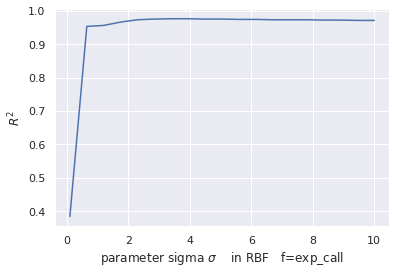

In [ ]:
plt.plot(sigma_list,R2_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

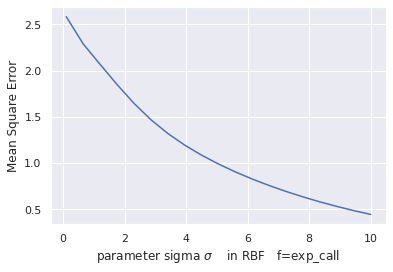

In [ ]:
plt.plot(sigma_list,error_sigma)
plt.xlabel(f'parameter sigma ' '$\\sigma \quad $ ' 'in RBF' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

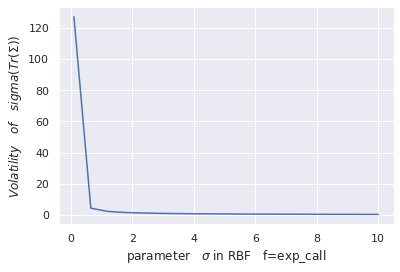

In [ ]:
plt.plot(sigma_list,cov_sigma)
plt.xlabel(f'parameter' '$\quad$' '$\sigma$' ' in RBF' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

# Test H 

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.1

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))


## For id


In [ ]:
f='id'
Hurst_list=np.linspace(0.1,0.9,9)
error_h=np.zeros((len(Hurst_list)))
R2_hurst=np.zeros((len(Hurst_list)))
cov_hurst=np.zeros((len(Hurst_list)))
for i in range (len(Hurst_list)):
  H=Hurst_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_h[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_hurst[i]=np.round(final_r2,3)
  cov_hurst[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 41.35it/s]


 sigma = 1 --- r2 = 0.99


100%|██████████| 30/30 [00:01<00:00, 27.49it/s]


 sigma = 1 --- r2 = 0.983


100%|██████████| 30/30 [00:00<00:00, 37.12it/s]


 sigma = 1 --- r2 = 0.978


100%|██████████| 30/30 [00:01<00:00, 27.73it/s]


 sigma = 1 --- r2 = 0.974


100%|██████████| 30/30 [00:00<00:00, 52.84it/s]


 sigma = 1 --- r2 = 0.965


100%|██████████| 30/30 [00:01<00:00, 26.50it/s]


 sigma = 1 --- r2 = 0.955


100%|██████████| 30/30 [00:01<00:00, 29.29it/s]


 sigma = 1 --- r2 = 0.947


100%|██████████| 30/30 [00:01<00:00, 28.21it/s]


 sigma = 1 --- r2 = 0.942


100%|██████████| 30/30 [00:00<00:00, 34.13it/s]


 sigma = 1 --- r2 = 0.942


Text(0, 0.5, '$R^2$')

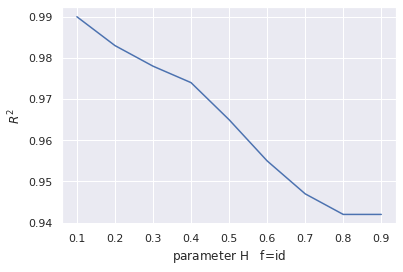

In [ ]:
plt.plot(Hurst_list,R2_hurst)
plt.xlabel(f'parameter H''$\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

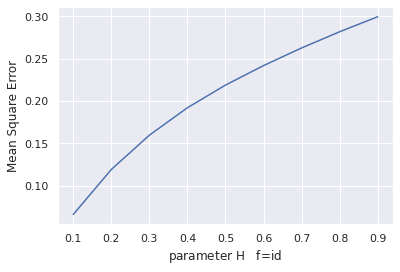

In [ ]:
plt.plot(Hurst_list,error_h)
plt.xlabel(f'parameter H' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

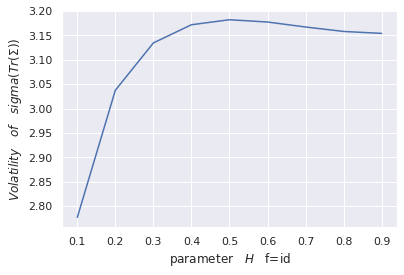

In [ ]:
plt.plot(Hurst_list,cov_hurst)
plt.xlabel(f'parameter' '$\quad$' '$H$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For abs

In [ ]:
f='abs'
Hurst_list=np.linspace(0.1,0.9,9)
error_h=np.zeros((len(Hurst_list)))
R2_hurst=np.zeros((len(Hurst_list)))
cov_hurst=np.zeros((len(Hurst_list)))
for i in range (len(Hurst_list)):
  H=Hurst_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_h[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_hurst[i]=np.round(final_r2,3)
  cov_hurst[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 44.27it/s]


 sigma = 1 --- r2 = 0.728


100%|██████████| 30/30 [00:00<00:00, 43.08it/s]


 sigma = 1 --- r2 = 0.763


100%|██████████| 30/30 [00:00<00:00, 44.30it/s]


 sigma = 1 --- r2 = 0.764


100%|██████████| 30/30 [00:00<00:00, 41.67it/s]


 sigma = 1 --- r2 = 0.736


100%|██████████| 30/30 [00:00<00:00, 72.49it/s]


 sigma = 1 --- r2 = 0.712


100%|██████████| 30/30 [00:00<00:00, 45.62it/s]


 sigma = 1 --- r2 = 0.695


100%|██████████| 30/30 [00:00<00:00, 44.52it/s]


 sigma = 1 --- r2 = 0.688


100%|██████████| 30/30 [00:00<00:00, 45.64it/s]


 sigma = 1 --- r2 = 0.676


100%|██████████| 30/30 [00:00<00:00, 45.66it/s]


 sigma = 1 --- r2 = 0.673


Text(0, 0.5, '$R^2$')

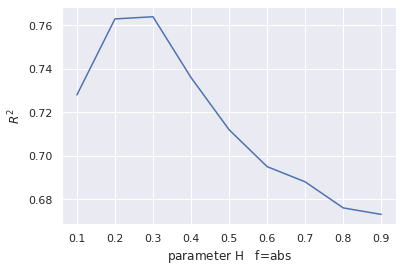

In [ ]:
plt.plot(Hurst_list,R2_hurst)
plt.xlabel(f'parameter H''$\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

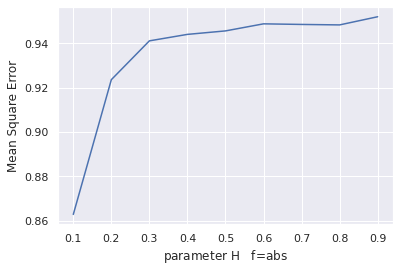

In [ ]:
plt.plot(Hurst_list,error_h)
plt.xlabel(f'parameter H' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

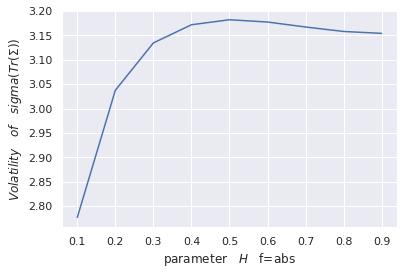

In [ ]:
plt.plot(Hurst_list,cov_hurst)
plt.xlabel(f'parameter' '$\quad$' '$H$'  '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For exp

In [ ]:
f='exp'
Hurst_list=np.linspace(0.1,0.9,9)
error_h=np.zeros((len(Hurst_list)))
R2_hurst=np.zeros((len(Hurst_list)))
cov_hurst=np.zeros((len(Hurst_list)))
for i in range (len(Hurst_list)):
  H=Hurst_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_h[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_hurst[i]=np.round(final_r2,3)
  cov_hurst[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 41.55it/s]


 sigma = 1 --- r2 = 0.951


100%|██████████| 30/30 [00:00<00:00, 43.35it/s]


 sigma = 1 --- r2 = 0.957


100%|██████████| 30/30 [00:00<00:00, 42.47it/s]


 sigma = 1 --- r2 = 0.95


100%|██████████| 30/30 [00:00<00:00, 45.32it/s]


 sigma = 1 --- r2 = 0.936


100%|██████████| 30/30 [00:00<00:00, 75.86it/s]


 sigma = 1 --- r2 = 0.918


100%|██████████| 30/30 [00:00<00:00, 42.98it/s]


 sigma = 1 --- r2 = 0.899


100%|██████████| 30/30 [00:00<00:00, 44.90it/s]


 sigma = 1 --- r2 = 0.885


100%|██████████| 30/30 [00:00<00:00, 46.96it/s]


 sigma = 1 --- r2 = 0.878


100%|██████████| 30/30 [00:00<00:00, 46.70it/s]


 sigma = 1 --- r2 = 0.879


Text(0, 0.5, '$R^2$')

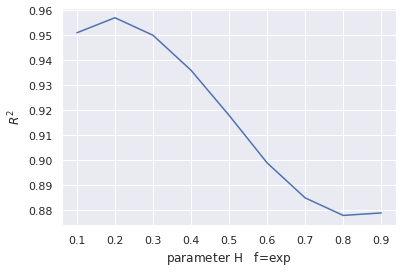

In [ ]:
plt.plot(Hurst_list,R2_hurst)
plt.xlabel(f'parameter H''$\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

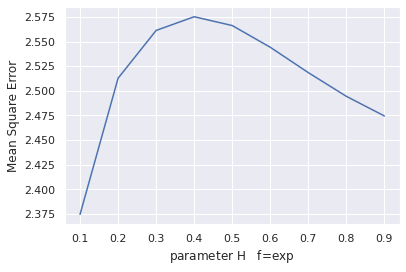

In [ ]:
plt.plot(Hurst_list,error_h)
plt.xlabel(f'parameter H' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

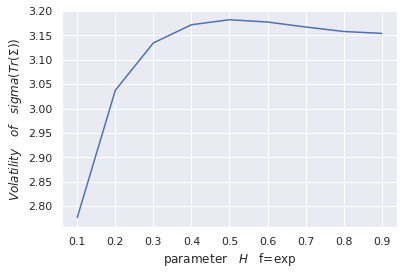

In [ ]:
plt.plot(Hurst_list,cov_hurst)
plt.xlabel(f'parameter' '$\quad$' '$H$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For call

In [ ]:
f='call'
Hurst_list=np.linspace(0.1,0.9,9)
error_h=np.zeros((len(Hurst_list)))
R2_hurst=np.zeros((len(Hurst_list)))
cov_hurst=np.zeros((len(Hurst_list)))
for i in range (len(Hurst_list)):
  H=Hurst_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_h[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_hurst[i]=np.round(final_r2,3)
  cov_hurst[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 42.89it/s]


 sigma = 1 --- r2 = 0.966


100%|██████████| 30/30 [00:00<00:00, 44.06it/s]


 sigma = 1 --- r2 = 0.959


100%|██████████| 30/30 [00:00<00:00, 43.18it/s]


 sigma = 1 --- r2 = 0.948


100%|██████████| 30/30 [00:00<00:00, 45.99it/s]


 sigma = 1 --- r2 = 0.937


100%|██████████| 30/30 [00:00<00:00, 74.44it/s]


 sigma = 1 --- r2 = 0.931


100%|██████████| 30/30 [00:00<00:00, 45.62it/s]


 sigma = 1 --- r2 = 0.93


100%|██████████| 30/30 [00:00<00:00, 38.88it/s]


 sigma = 1 --- r2 = 0.928


100%|██████████| 30/30 [00:00<00:00, 46.21it/s]


 sigma = 1 --- r2 = 0.926


100%|██████████| 30/30 [00:00<00:00, 46.62it/s]


 sigma = 1 --- r2 = 0.934


Text(0, 0.5, '$R^2$')

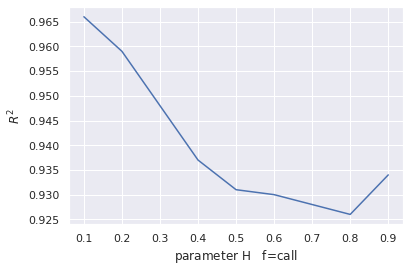

In [ ]:
plt.plot(Hurst_list,R2_hurst)
plt.xlabel(f'parameter H''$\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

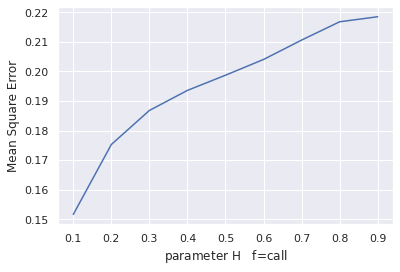

In [ ]:
plt.plot(Hurst_list,error_h)
plt.xlabel(f'parameter H' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

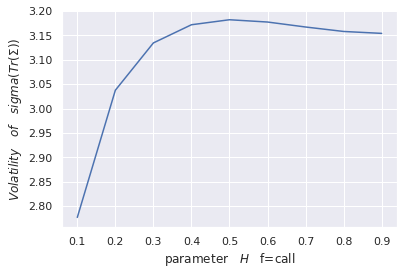

In [ ]:
plt.plot(Hurst_list,cov_hurst)
plt.xlabel(f'parameter' '$\quad$' '$H$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For expcall

In [ ]:
f='exp_call'
Hurst_list=np.linspace(0.1,0.9,9)
error_h=np.zeros((len(Hurst_list)))
R2_hurst=np.zeros((len(Hurst_list)))
cov_hurst=np.zeros((len(Hurst_list)))
for i in range (len(Hurst_list)):
  H=Hurst_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_h[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_hurst[i]=np.round(final_r2,3)
  cov_hurst[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 42.19it/s]


 sigma = 1 --- r2 = 0.955


100%|██████████| 30/30 [00:00<00:00, 43.54it/s]


 sigma = 1 --- r2 = 0.959


100%|██████████| 30/30 [00:00<00:00, 43.21it/s]


 sigma = 1 --- r2 = 0.952


100%|██████████| 30/30 [00:00<00:00, 44.93it/s]


 sigma = 1 --- r2 = 0.938


100%|██████████| 30/30 [00:00<00:00, 73.18it/s]


 sigma = 1 --- r2 = 0.921


100%|██████████| 30/30 [00:00<00:00, 45.36it/s]


 sigma = 1 --- r2 = 0.904


100%|██████████| 30/30 [00:00<00:00, 45.58it/s]


 sigma = 1 --- r2 = 0.891


100%|██████████| 30/30 [00:00<00:00, 44.95it/s]


 sigma = 1 --- r2 = 0.885


100%|██████████| 30/30 [00:00<00:00, 46.07it/s]


 sigma = 1 --- r2 = 0.886


Text(0, 0.5, '$R^2$')

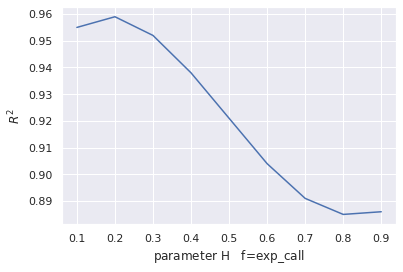

In [ ]:
plt.plot(Hurst_list,R2_hurst)
plt.xlabel(f'parameter H''$\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

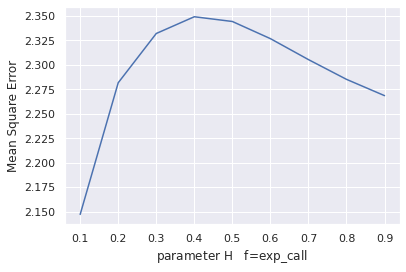

In [ ]:
plt.plot(Hurst_list,error_h)
plt.xlabel(f'parameter H' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error' )

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

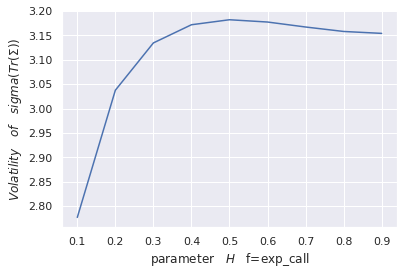

In [ ]:
plt.plot(Hurst_list,cov_hurst)
plt.xlabel(f'parameter' '$\quad$' '$H$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

# Test $\nu$ in absolute


In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.7

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))

In [ ]:
f='exp'
nu_list=np.linspace(-3,3,13)
error_nu=np.zeros((len(nu_list)))
R2_nu=np.zeros((len(nu_list)))
cov_nu=np.zeros((len(nu_list)))
for i in range (len(nu_list)):
  nu=nu_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()

  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))




  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_nu[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_nu[i]=np.round(final_r2,3)
  cov_nu[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 45.44it/s]


 sigma = 1 --- r2 = 0.538


100%|██████████| 30/30 [00:00<00:00, 45.46it/s]


 sigma = 1 --- r2 = 0.717


100%|██████████| 30/30 [00:01<00:00, 23.15it/s]


 sigma = 1 --- r2 = 0.823


100%|██████████| 30/30 [00:01<00:00, 26.57it/s]


 sigma = 1 --- r2 = 0.895


100%|██████████| 30/30 [00:00<00:00, 43.12it/s]


 sigma = 1 --- r2 = 0.945


100%|██████████| 30/30 [00:01<00:00, 26.02it/s]


 sigma = 1 --- r2 = 0.969


100%|██████████| 30/30 [00:01<00:00, 26.15it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 39.21it/s]


 sigma = 1 --- r2 = 0.89


100%|██████████| 30/30 [00:00<00:00, 45.28it/s]


 sigma = 1 --- r2 = 0.951


100%|██████████| 30/30 [00:00<00:00, 45.59it/s]


 sigma = 1 --- r2 = 0.926


100%|██████████| 30/30 [00:00<00:00, 44.59it/s]


 sigma = 1 --- r2 = 0.871


100%|██████████| 30/30 [00:00<00:00, 44.33it/s]


 sigma = 1 --- r2 = 0.773


100%|██████████| 30/30 [00:00<00:00, 44.40it/s]


 sigma = 1 --- r2 = 0.621


Text(0, 0.5, '$R^2$')

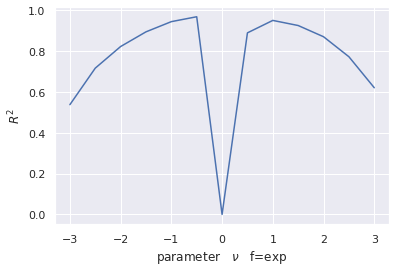

In [ ]:
plt.plot(nu_list,R2_nu)
plt.xlabel(f'parameter''$\quad \\nu\quad$'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Error')

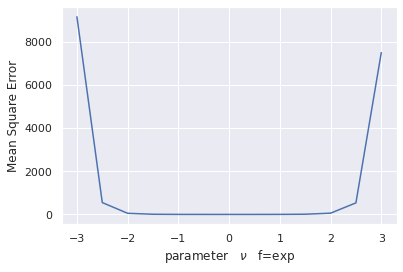

In [ ]:
plt.plot(nu_list,error_nu)
plt.xlabel(f'parameter' '$\quad \\nu$''$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Error')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

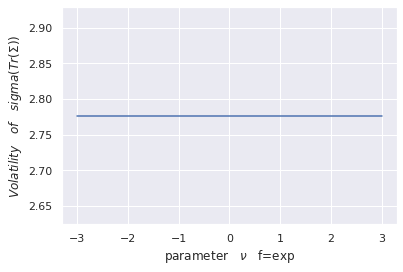

In [ ]:
plt.plot(nu_list,cov_nu)
plt.xlabel(f'parameter' '$\quad \\nu$''$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

# Test strike in call

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.7

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))

# Positive strike

In [ ]:
f='call'
strike_call_list=np.linspace(0.,3.,11)
error_call=np.zeros((len(strike_call_list)))
R2_call=np.zeros((len(strike_call_list)))
cov_call=np.zeros((len(strike_call_list)))
for i in range (len(strike_call_list)):
  strike=strike_call_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_call[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_call[i]=np.round(final_r2,3)
  cov_call[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 44.02it/s]


 sigma = 1 --- r2 = 0.975


100%|██████████| 30/30 [00:00<00:00, 43.83it/s]


 sigma = 1 --- r2 = 0.903


100%|██████████| 30/30 [00:00<00:00, 43.79it/s]


 sigma = 1 --- r2 = 0.851


100%|██████████| 30/30 [00:00<00:00, 44.79it/s]


 sigma = 1 --- r2 = 0.849


100%|██████████| 30/30 [00:00<00:00, 43.78it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 44.46it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 34.67it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 44.50it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 44.37it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 43.67it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 44.67it/s]


 sigma = 1 --- r2 = nan


Text(0, 0.5, '$R^2$')

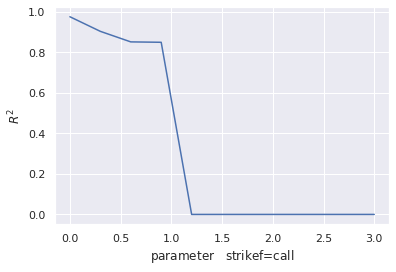

In [ ]:
plt.plot(strike_call_list,R2_call)
plt.xlabel(f'parameter''$\quad$' 'strike'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

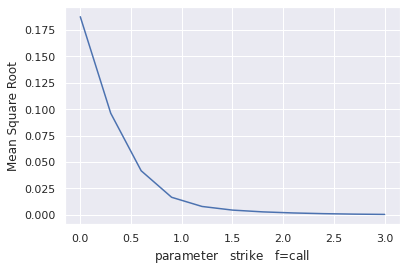

In [ ]:
plt.plot(strike_call_list,error_call)
plt.xlabel(f'parameter' '$\quad$' 'strike' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad$\\Sigma $$(Tr(\\Sigma))$')

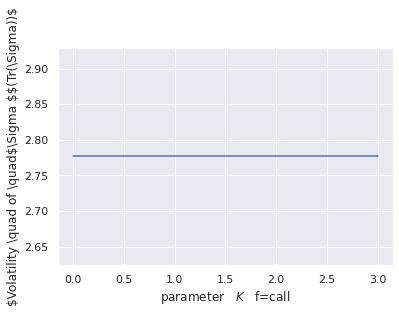

In [ ]:
plt.plot(strike_call_list,cov_call)
plt.xlabel(f'parameter' '$\quad K $''$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad' '$\Sigma $' '$(Tr(\Sigma))$')

## Negative strike


In [ ]:
f='call'
strike_call_list=np.linspace(-20.,0.,21)
error_call=np.zeros((len(strike_call_list)))
R2_call=np.zeros((len(strike_call_list)))
cov_call=np.zeros((len(strike_call_list)))
for i in range (len(strike_call_list)):
  strike=strike_call_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_call[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_call[i]=np.round(final_r2,3)
  cov_call[i]=np.trace(cov)/m_A

100%|██████████| 30/30 [00:00<00:00, 31.62it/s]


 sigma = 1 --- r2 = 0.885


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


 sigma = 1 --- r2 = 0.883


100%|██████████| 30/30 [00:00<00:00, 41.93it/s]


 sigma = 1 --- r2 = 0.881


100%|██████████| 30/30 [00:00<00:00, 45.43it/s]


 sigma = 1 --- r2 = 0.878


100%|██████████| 30/30 [00:00<00:00, 44.31it/s]


 sigma = 1 --- r2 = 0.874


100%|██████████| 30/30 [00:00<00:00, 42.34it/s]


 sigma = 1 --- r2 = 0.87


100%|██████████| 30/30 [00:01<00:00, 26.07it/s]


 sigma = 1 --- r2 = 0.865


100%|██████████| 30/30 [00:01<00:00, 25.85it/s]


 sigma = 1 --- r2 = 0.858


100%|██████████| 30/30 [00:00<00:00, 43.41it/s]


 sigma = 1 --- r2 = 0.85


100%|██████████| 30/30 [00:00<00:00, 43.58it/s]


 sigma = 1 --- r2 = 0.84


100%|██████████| 30/30 [00:00<00:00, 30.75it/s]


 sigma = 1 --- r2 = 0.826


100%|██████████| 30/30 [00:00<00:00, 40.19it/s]


 sigma = 1 --- r2 = 0.806


100%|██████████| 30/30 [00:00<00:00, 33.03it/s]


 sigma = 1 --- r2 = 0.777


100%|██████████| 30/30 [00:00<00:00, 43.90it/s]


 sigma = 1 --- r2 = 0.729


100%|██████████| 30/30 [00:01<00:00, 25.96it/s]


 sigma = 1 --- r2 = 0.64


100%|██████████| 30/30 [00:01<00:00, 27.45it/s]


 sigma = 1 --- r2 = 0.445


100%|██████████| 30/30 [00:00<00:00, 40.91it/s]


 sigma = 1 --- r2 = 0.049


100%|██████████| 30/30 [00:01<00:00, 26.71it/s]


 sigma = 1 --- r2 = 0.448


100%|██████████| 30/30 [00:01<00:00, 27.08it/s]


 sigma = 1 --- r2 = 0.912


100%|██████████| 30/30 [00:01<00:00, 29.33it/s]


 sigma = 1 --- r2 = 0.982


100%|██████████| 30/30 [00:00<00:00, 38.29it/s]


 sigma = 1 --- r2 = 0.975


Text(0, 0.5, '$R^2$')

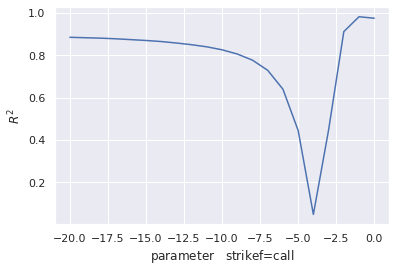

In [ ]:
plt.plot(strike_call_list,R2_call)
plt.xlabel(f'parameter''$\quad$' 'strike'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

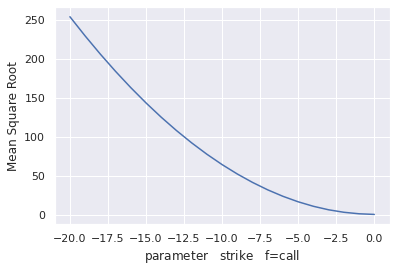

In [ ]:
plt.plot(strike_call_list,error_call)
plt.xlabel(f'parameter' '$\quad$' 'strike' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad$\\Sigma $$(Tr(\\Sigma))$')

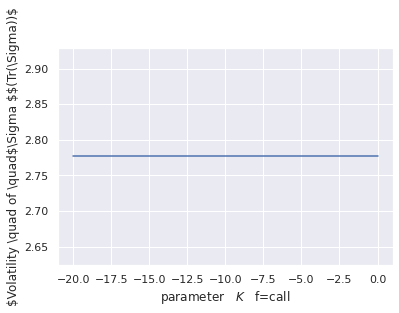

In [ ]:
plt.plot(strike_call_list,cov_call)
plt.xlabel(f'parameter' '$\quad K $''$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad' '$\Sigma $' '$(Tr(\Sigma))$')

# Test strike for exponential call

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.7

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))

In [ ]:
f='exp_call'
strike_call_list=np.linspace(0.,5.,11)
error_call=np.zeros((len(strike_call_list)))
R2_call=np.zeros((len(strike_call_list)))
cov_call=np.zeros((len(strike_call_list)))
for i in range (len(strike_call_list)):
  strike=strike_call_list[i]
  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()

  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  G_inv = torch.cholesky_inverse(G)

  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))


  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_call[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_call[i]=np.round(final_r2,3)
  cov_call[i]=np.trace(cov)/m_A
  

100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


 sigma = 1 --- r2 = 0.951


100%|██████████| 30/30 [00:00<00:00, 42.85it/s]


 sigma = 1 --- r2 = 0.964


100%|██████████| 30/30 [00:00<00:00, 44.80it/s]


 sigma = 1 --- r2 = 0.931


100%|██████████| 30/30 [00:00<00:00, 44.53it/s]


 sigma = 1 --- r2 = 0.792


100%|██████████| 30/30 [00:00<00:00, 44.13it/s]


 sigma = 1 --- r2 = 0.722


100%|██████████| 30/30 [00:00<00:00, 44.08it/s]


 sigma = 1 --- r2 = 0.795


100%|██████████| 30/30 [00:00<00:00, 44.39it/s]


 sigma = 1 --- r2 = 0.906


100%|██████████| 30/30 [00:00<00:00, 43.43it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 44.93it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 45.01it/s]


 sigma = 1 --- r2 = nan


100%|██████████| 30/30 [00:00<00:00, 45.57it/s]


 sigma = 1 --- r2 = nan


Text(0, 0.5, '$R^2$')

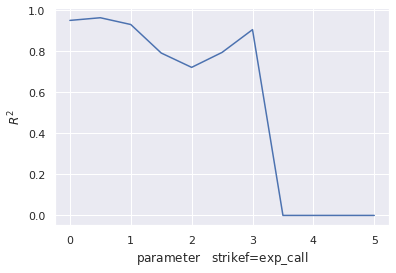

In [ ]:
plt.plot(strike_call_list,R2_call)
plt.xlabel(f'parameter''$\quad$' 'strike'  f'f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

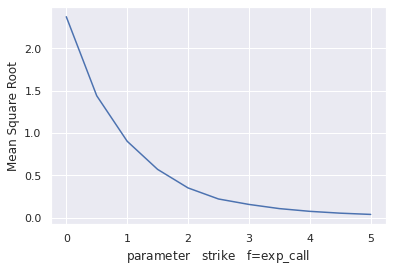

In [ ]:
plt.plot(strike_call_list,error_call)
plt.xlabel(f'parameter' '$\quad$' 'strike' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad$\\Sigma $$(Tr(\\Sigma))$')

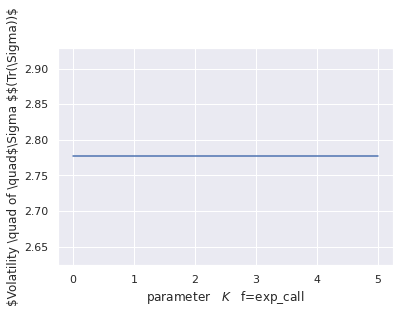

In [ ]:
plt.plot(strike_call_list,cov_call)
plt.xlabel(f'parameter' '$\quad K $''$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad' '$\Sigma $' '$(Tr(\Sigma))$')

# f=Id Test $m_A$

In [ ]:
m_A=30
m_B=30
H=0.1
l=m_A
T=1
sigma=1
scale=1e-2

#payoff
f='exp_call'
nu=1.
strike=0.7

m=30
time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
np.random.seed(1)
time_indices_ = random.sample(time_indices, m) #generate random m groups 
t_grid = [t for _,t in time_indices_]
t_grid.sort()
t_grid = torch.tensor(t_grid)

t_grid_A=np.linspace(0,T,l)
t_grid_B=T*np.ones((m_B))

## For id

In [ ]:
f='id'
mA_list=np.linspace(5,35,11)
error_mA=np.zeros((len(mA_list)))
R2_mA=np.zeros((len(mA_list)))
cov_mA=np.zeros((len(mA_list)))
for i in range (len(mA_list)):
  m_A=mA_list[i].astype(int)
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  sigma=15.
  #sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_mA[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_mA[i]=np.round(final_r2,3)
  cov_mA[i]=np.trace(cov)/m_A

100%|██████████| 5/5 [00:00<00:00, 865.73it/s]


 sigma = 15.0 --- r2 = 0.985


100%|██████████| 8/8 [00:00<00:00, 328.46it/s]


 sigma = 15.0 --- r2 = 1.0


100%|██████████| 11/11 [00:00<00:00, 244.08it/s]


 sigma = 15.0 --- r2 = 0.999


100%|██████████| 14/14 [00:00<00:00, 169.16it/s]


 sigma = 15.0 --- r2 = 0.999


100%|██████████| 17/17 [00:00<00:00, 117.50it/s]


 sigma = 15.0 --- r2 = 0.998


100%|██████████| 20/20 [00:00<00:00, 76.55it/s] 


 sigma = 15.0 --- r2 = 0.999


100%|██████████| 23/23 [00:00<00:00, 66.64it/s] 


 sigma = 15.0 --- r2 = 0.998


100%|██████████| 26/26 [00:00<00:00, 30.17it/s]


 sigma = 15.0 --- r2 = 0.998


100%|██████████| 29/29 [00:01<00:00, 24.06it/s]


 sigma = 15.0 --- r2 = 0.998


100%|██████████| 32/32 [00:01<00:00, 23.56it/s]


 sigma = 15.0 --- r2 = 0.999


100%|██████████| 35/35 [00:01<00:00, 28.96it/s]


 sigma = 15.0 --- r2 = 0.999


Text(0, 0.5, '$R^2$')

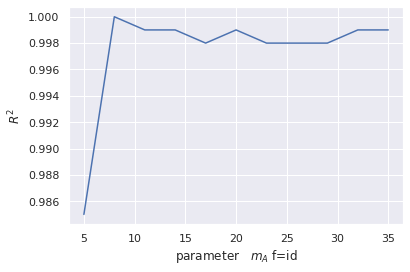

In [ ]:
plt.plot(mA_list,R2_mA)
plt.xlabel(f'parameter''$\quad$' '$m_A$'  f' f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

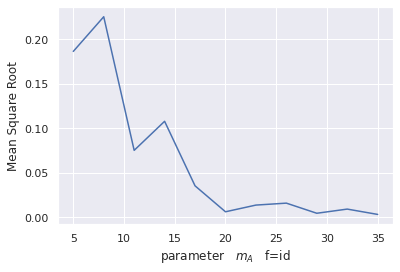

In [ ]:
plt.plot(mA_list,error_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

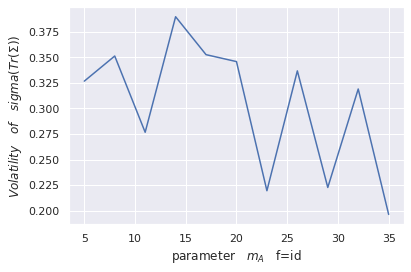

In [ ]:
plt.plot(mA_list,cov_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For abs


In [ ]:
f='abs'
mA_list=np.linspace(5,35,11)
error_mA=np.zeros((len(mA_list)))
R2_mA=np.zeros((len(mA_list)))
cov_mA=np.zeros((len(mA_list)))
for i in range (len(mA_list)):
  m_A=mA_list[i].astype(int)
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  sigma=15.
  #sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_mA[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_mA[i]=np.round(final_r2,3)
  cov_mA[i]=np.trace(cov)/m_A

100%|██████████| 5/5 [00:00<00:00, 765.47it/s]


 sigma = 15.0 --- r2 = 0.173


100%|██████████| 8/8 [00:00<00:00, 409.27it/s]


 sigma = 15.0 --- r2 = 0.075


100%|██████████| 11/11 [00:00<00:00, 270.16it/s]


 sigma = 15.0 --- r2 = 0.847


100%|██████████| 14/14 [00:00<00:00, 174.50it/s]


 sigma = 15.0 --- r2 = 0.119


100%|██████████| 17/17 [00:00<00:00, 121.15it/s]


 sigma = 15.0 --- r2 = 0.909


100%|██████████| 20/20 [00:00<00:00, 90.23it/s] 


 sigma = 15.0 --- r2 = 0.038


100%|██████████| 23/23 [00:00<00:00, 68.37it/s] 


 sigma = 15.0 --- r2 = 0.001


100%|██████████| 26/26 [00:00<00:00, 53.37it/s]


 sigma = 15.0 --- r2 = 0.005


100%|██████████| 29/29 [00:00<00:00, 43.80it/s]


 sigma = 15.0 --- r2 = 0.186


100%|██████████| 32/32 [00:00<00:00, 35.77it/s]


 sigma = 15.0 --- r2 = 0.373


100%|██████████| 35/35 [00:01<00:00, 29.77it/s]


 sigma = 15.0 --- r2 = 0.695


Text(0, 0.5, '$R^2$')

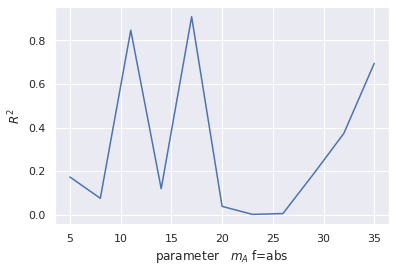

In [ ]:
plt.plot(mA_list,R2_mA)
plt.xlabel(f'parameter''$\quad$' '$m_A$'  f' f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

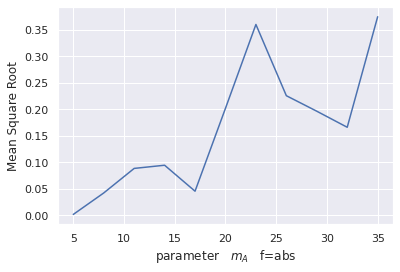

In [ ]:
plt.plot(mA_list,error_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

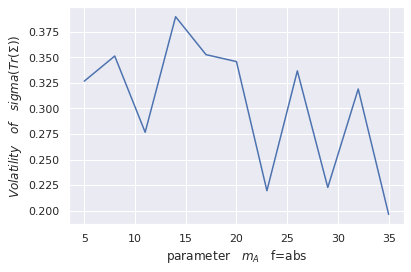

In [ ]:
plt.plot(mA_list,cov_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For exp

In [ ]:
f='exp'
mA_list=np.linspace(5,35,7)
error_mA=np.zeros((len(mA_list)))
R2_mA=np.zeros((len(mA_list)))
cov_mA=np.zeros((len(mA_list)))
for i in range (len(mA_list)):
  m_A=mA_list[i].astype(int)
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  sigma=15.
  #sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_mA[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_mA[i]=np.round(final_r2,3)
  cov_mA[i]=np.trace(cov)/m_A

100%|██████████| 5/5 [00:00<00:00, 652.16it/s]


 sigma = 15.0 --- r2 = 0.094


100%|██████████| 10/10 [00:00<00:00, 268.44it/s]


 sigma = 15.0 --- r2 = 0.983


100%|██████████| 15/15 [00:00<00:00, 155.54it/s]


 sigma = 15.0 --- r2 = 0.971


100%|██████████| 20/20 [00:00<00:00, 87.05it/s] 


 sigma = 15.0 --- r2 = 0.989


100%|██████████| 25/25 [00:00<00:00, 56.83it/s]


 sigma = 15.0 --- r2 = 0.955


100%|██████████| 30/30 [00:01<00:00, 29.26it/s]


 sigma = 15.0 --- r2 = 0.968


100%|██████████| 35/35 [00:01<00:00, 28.29it/s]


 sigma = 15.0 --- r2 = 0.968


Text(0, 0.5, '$R^2$')

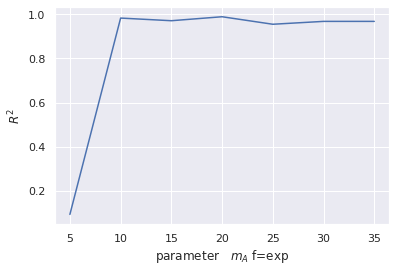

In [ ]:
plt.plot(mA_list,R2_mA)
plt.xlabel(f'parameter''$\quad$' '$m_A$'  f' f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

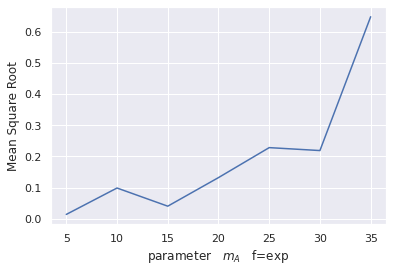

In [ ]:
plt.plot(mA_list,error_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

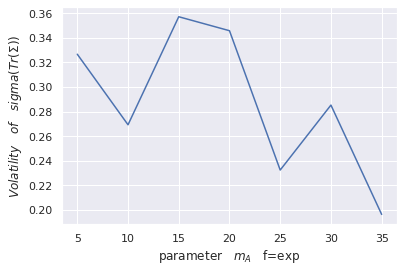

In [ ]:
plt.plot(mA_list,cov_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## For call

In [ ]:
f='call'
mA_list=np.linspace(5,35,7)
error_mA=np.zeros((len(mA_list)))
R2_mA=np.zeros((len(mA_list)))
cov_mA=np.zeros((len(mA_list)))
for i in range (len(mA_list)):
  m_A=mA_list[i].astype(int)
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  sigma=15.
  #sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_mA[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_mA[i]=np.round(final_r2,3)
  cov_mA[i]=np.trace(cov)/m_A

100%|██████████| 5/5 [00:00<00:00, 773.12it/s]


 sigma = 15.0 --- r2 = 0.877


100%|██████████| 10/10 [00:00<00:00, 183.44it/s]


 sigma = 15.0 --- r2 = 0.752


100%|██████████| 15/15 [00:00<00:00, 84.64it/s] 


 sigma = 15.0 --- r2 = 0.877


100%|██████████| 20/20 [00:00<00:00, 49.38it/s]


 sigma = 15.0 --- r2 = 0.906


100%|██████████| 25/25 [00:00<00:00, 47.77it/s]


 sigma = 15.0 --- r2 = 0.938


100%|██████████| 30/30 [00:01<00:00, 27.41it/s]


 sigma = 15.0 --- r2 = 0.925


100%|██████████| 35/35 [00:01<00:00, 21.14it/s]


 sigma = 15.0 --- r2 = 0.94


Text(0, 0.5, '$R^2$')

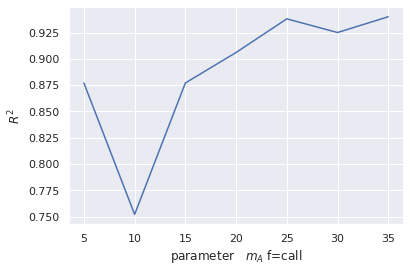

In [ ]:
plt.plot(mA_list,R2_mA)
plt.xlabel(f'parameter''$\quad$' '$m_A$'  f' f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

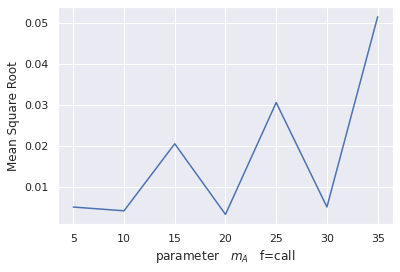

In [ ]:
plt.plot(mA_list,error_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

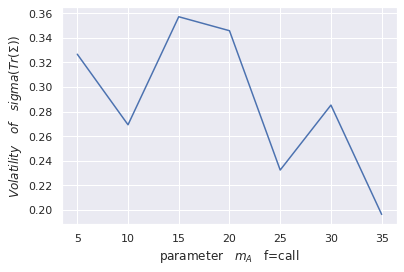

In [ ]:
plt.plot(mA_list,cov_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')

## for expcall

In [ ]:
f='exp_call'
mA_list=np.linspace(5,35,7)
error_mA=np.zeros((len(mA_list)))
R2_mA=np.zeros((len(mA_list)))
cov_mA=np.zeros((len(mA_list)))
for i in range (len(mA_list)):
  m_A=mA_list[i].astype(int)
  m_B=m_A
  H=0.1
  l=m_A
  T=1
  sigma=15.
  #sigma=sigma_list[i]
  scale=1e-2

  #payoff
  #f='id'
  nu=1.
  strike=0.7

  m=m_A
  time_indices = [(i,t_i) for i,t_i in zip(np.arange(l), np.linspace(0,T,l))]
  np.random.seed(1)
  time_indices_ = random.sample(time_indices, m) #generate random m groups 
  t_grid = [t for _,t in time_indices_]
  t_grid.sort()
  t_grid = torch.tensor(t_grid)

  t_grid_A=np.linspace(0,T,l)
  t_grid_B=T*np.ones((m_B))

  a=KernelPathHeat(m_A,m_B,l,H,T,sigma,scale,f,nu,strike,m)
  h_A=scale*a.h_path(t_grid_A)
  path_A=a.generatePath_A()
  path_B=a.generatePath_B()
  paths,sol_true=a.generatePaths()
  h=scale*a.h_path(t_grid)

  path_A=path_A.double()
  path_B=path_B.double()
  paths=paths.double()
  
  
  y=generateY(f,m_A,m_B,path_B,strike,nu)
  G=generateG(path_A,path_B,t_grid_A,t_grid_B,sigma,h_A)
  x=generateX(paths,path_A,path_B,t_grid,t_grid_A,t_grid_B,h,sigma)
  #G_inv = torch.linalg.inv(G)
  G_inv=torch.cholesky_inverse(G)


  
  x=x.double()
  y=y.double()
  G_inv=G_inv.double()


  pred = torch.matmul(x.to(device), torch.matmul(G_inv.to(device), y.to(device)))
  pred=pred.cpu().numpy()
  pred=pred.reshape(1,-1)
  pred=pred[0,:]

  X1=generateX1(path_A,paths,path_B,t_grid_A,t_grid,t_grid_B,h_A,sigma)
  K1=generateK(paths,t_grid,sigma)
  cov=K1-torch.matmul(x.to(device), torch.matmul(G_inv.to(device), X1.to(device)))

  final_r2 = 0.
  temp_r2 = r2(sol_true,pred)
  print(f' sigma = {np.round(sigma,2)} ---', f'r2 = {np.round(temp_r2,3)}')
  if temp_r2 > final_r2:
      final_r2 = temp_r2
      sol_pred = pred
  #sol_true.cpu().numpy()
  error_mA[i]=np.sum((sol_pred-sol_true.cpu().numpy())**2)/m
  R2_mA[i]=np.round(final_r2,3)
  cov_mA[i]=np.trace(cov)/m_A

100%|██████████| 5/5 [00:00<00:00, 523.36it/s]


 sigma = 15.0 --- r2 = 0.016


100%|██████████| 10/10 [00:00<00:00, 208.19it/s]


 sigma = 15.0 --- r2 = 0.974


100%|██████████| 15/15 [00:00<00:00, 107.04it/s]


 sigma = 15.0 --- r2 = 0.954


100%|██████████| 20/20 [00:00<00:00, 48.20it/s]


 sigma = 15.0 --- r2 = 0.984


100%|██████████| 25/25 [00:00<00:00, 53.87it/s]


 sigma = 15.0 --- r2 = 0.939


100%|██████████| 30/30 [00:00<00:00, 38.56it/s]


 sigma = 15.0 --- r2 = 0.957


100%|██████████| 35/35 [00:01<00:00, 29.44it/s]


 sigma = 15.0 --- r2 = 0.961


Text(0, 0.5, '$R^2$')

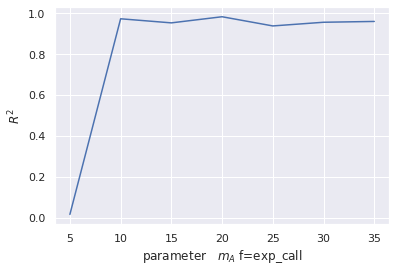

In [ ]:
plt.plot(mA_list,R2_mA)
plt.xlabel(f'parameter''$\quad$' '$m_A$'  f' f={f}')
plt.ylabel(f'$R^2$' )

Text(0, 0.5, 'Mean Square Root')

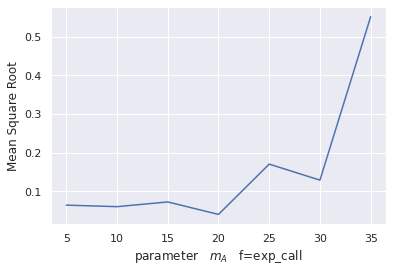

In [ ]:
plt.plot(mA_list,error_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel(f'Mean Square Root')

Text(0, 0.5, '$Volatility \\quad of \\quad sigma (Tr(\\Sigma))$')

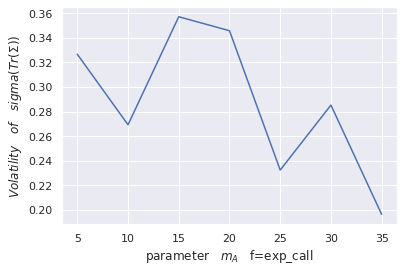

In [ ]:
plt.plot(mA_list,cov_mA)
plt.xlabel(f'parameter' '$\quad$' '$m_A$' '$\quad$' f'f={f}')
plt.ylabel('$Volatility \quad of \quad sigma (Tr(\Sigma))$')